In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import magma
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
pd.set_option("display.max_columns",None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')  # Adjust precision as needed


In [2]:
def data_ingestion_npcl(data_path=None):
    df = pd.read_csv(data_path, parse_dates=['creation_time'])
    data = df.copy()
    data_length = len(data)
    no_of_feeders = data['location_id'].nunique()
    print(f"stats at starting: \n total data points: {data_length}, \n no of location_id: {no_of_feeders}.")
    # data.drop(["status","id","error_reason"],axis=1,inplace= True)
    data.drop(['id'],axis= 1,inplace= True)    
    # data = data.loc[data['location_id']!= 100000011999]
    # data = data.loc[~data['location_id'].isin([100000011999, 100000190001, 100000030201, 100000011203])]
    null_values = data.isna().sum().sum()
    print(f"null values: {null_values}")
    if null_values != 0:
        data.dropna(inplace= True)
        print(f"dropped null values")
        print(f"null values: {data.isna().sum().sum()}") 
    duplicate_values = data.duplicated().sum()
    print(f"duplicate values: {duplicate_values}")
    if duplicate_values != 0:
        data.drop_duplicates(inplace = True)
        print(f"duplicate values dropped, current duplicate values: {data.duplicated().sum()}")
    
    # Dictionary to rename columns
    rename_dict = {
        'R_voltage': 'R_Voltage',
        'Y_volatge': 'Y_Voltage',
        'B_voltage': 'B_Voltage',
        'r_current': 'R_Current',
        'y_current': 'Y_Current',
        'b_current': 'B_Current',
        'r_pf': 'R_PF',
        'y_pf': 'Y_PF',
        'b_pf': 'B_PF',
        'instant_cum_Kw': 'Load_kW',
        'instant_cum_Kva': 'Load_KVA',
        'grid_reading_kwh': 'grid_reading_kwh',  
        'creation_time': 'creation_time'
    }
    # Rename columns
    data.rename(columns=rename_dict, inplace=True)
    data = data[['location_id', 'creation_time', 'frequency', 'R_Voltage', 'Y_Voltage', 'B_Voltage',
            'R_Current', 'Y_Current', 'B_Current', 'R_PF', 'Y_PF', 'B_PF', 'Load_kW', 'Load_KVA',
            'grid_reading_kwh','grid_reading_kvah'
            ,"error_reason"
            ]]
    data.sort_values("creation_time", inplace= True)
    data.reset_index(drop=True,inplace=True)
    print(f"stats after: \n total data points: {len(data)}, \n no of location_id: {data['location_id'].nunique()}.")
    # data.sort_index(inplace=True)
    print("#############--data ingestion done--".ljust(180,"#"))
    print()
    return data

def data_filter_condition(data= None):
    # Combining all conditions into one
    print(f"length in starting: {len(data)}")
    combined_condition = (
        # Frequency should be between 49 and 51
        (data['frequency'] !=0) & ((data['frequency'] > 51) | (data['frequency'] < 49))  |
        # Any PF outside the range [-1, 1]
        (data[['R_PF', 'Y_PF', 'B_PF']].abs() > 1).any(axis=1) |
        # All voltages are zero and either Load kW is non-zero or all currents are non-zero
        ((data[['R_Voltage', 'Y_Voltage', 'B_Voltage']].eq(0).all(axis=1)) &
        ((data['Load_kW'] != 0) | 
        (data[['R_Current', 'Y_Current', 'B_Current']].ne(0).all(axis=1)))) |
        # All currents are zero and either Load kW or Load KVA is greater than 0.03
        ((data[['R_Current', 'Y_Current', 'B_Current']].eq(0).all(axis=1)) &
        ((data['Load_kW'] > 0.03) | (data['Load_KVA'] > 0.03))) |
        # Load kW cannot be greater than Load KVA
        (data['Load_kW'] > data['Load_KVA'])
    )
    # Applying the combined condition
    data = data.loc[~combined_condition]
    print(f"length in ending: {len(data)}")
    data.reset_index(drop=True,inplace=True)
    summary = data.iloc[:, 2:14].describe()
    print(f"after cleaning dataframe stats")
    print(f"{tabulate(summary.round(2), headers='keys', tablefmt='pretty')}")
    print("#############--data filtering done--".ljust(180,"#"))
    print()
    return data

def data_cleaning_and_validation(df=None):
    print(f"date_time data type: {df['creation_time'].dtype}")
    if df['creation_time'].dtype not in ['<M8[ns]',"datetime64[ns]"]:
        df['creation_time'] = pd.to_datetime(df['creation_time'])
    for col in df.columns:
        if df[col].dtype == object:
            print(f"columns with categorical values: {col}")
    summary = df.iloc[:, 2:14].describe()
    print(f"before cleaning dataframe stats")
    print(f"{tabulate(summary.round(2), headers='keys', tablefmt='pretty')}")
    df = data_filter_condition(df)
    print("#############--data cleaning and validation done--".ljust(180,"#"))
    print()
    return df

In [3]:
data_path = r"C:\Users\HARSH/Downloads/output.csv"
df = data_ingestion_npcl(data_path=data_path)
data = data_cleaning_and_validation(df)

stats at starting: 
 total data points: 2048573, 
 no of location_id: 340.
null values: 0
duplicate values: 18239
duplicate values dropped, current duplicate values: 0
stats after: 
 total data points: 2030334, 
 no of location_id: 340.
#############--data ingestion done--################################################################################################################################################

date_time data type: datetime64[ns]
columns with categorical values: error_reason
before cleaning dataframe stats
+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       | frequency | R_Voltage | Y_Voltage | B_Voltage | R_Current | Y_Current | B_Current |   R_PF    |   Y_PF    |   B_PF    |  Load_kW  | Load_KVA  |
+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| cou

In [10]:
data.iloc[:,:-1]
# data.iloc[:, 2:14]

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah
0,100000020805,2024-07-01 00:00:00,50.00,243.10,246.20,240.90,0.00,0.00,0.26,1.00,1.00,1.00,0.07,0.07,7548.00,7822.00
1,100000031104,2024-07-01 00:00:00,50.00,243.80,247.00,241.50,0.26,1.61,0.70,1.00,0.99,0.73,0.64,0.69,9233.00,9766.00
2,100000040406,2024-07-01 00:00:00,50.00,243.00,247.10,242.50,0.22,0.00,1.44,1.00,1.00,1.00,0.45,0.45,8309.00,8777.00
3,100000040701,2024-07-01 00:00:03,50.00,243.10,246.90,242.10,3.69,3.30,0.63,0.97,0.99,0.80,1.80,1.86,22971.00,23774.00
4,100000020806,2024-07-01 00:00:03,50.00,243.00,246.70,240.80,0.00,6.65,0.00,1.00,1.00,1.00,1.64,1.64,4288.00,4666.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957099,100000020006,2024-07-31 23:59:53,50.00,248.40,250.80,249.10,0.00,0.00,0.58,1.00,1.00,0.97,0.14,0.15,2665.00,2961.00
1957100,100000030505,2024-07-31 23:59:53,50.00,249.50,250.20,249.00,0.20,0.08,6.39,0.98,1.00,0.99,1.66,1.68,13373.00,13697.00
1957101,100000041205,2024-07-31 23:59:55,50.00,248.30,251.50,247.80,0.00,0.29,2.08,1.00,0.67,0.93,0.52,0.58,24176.00,25079.00
1957102,100000030506,2024-07-31 23:59:56,50.00,249.80,249.80,249.50,0.89,2.26,0.00,0.99,0.96,1.00,0.99,1.01,7094.00,7841.00


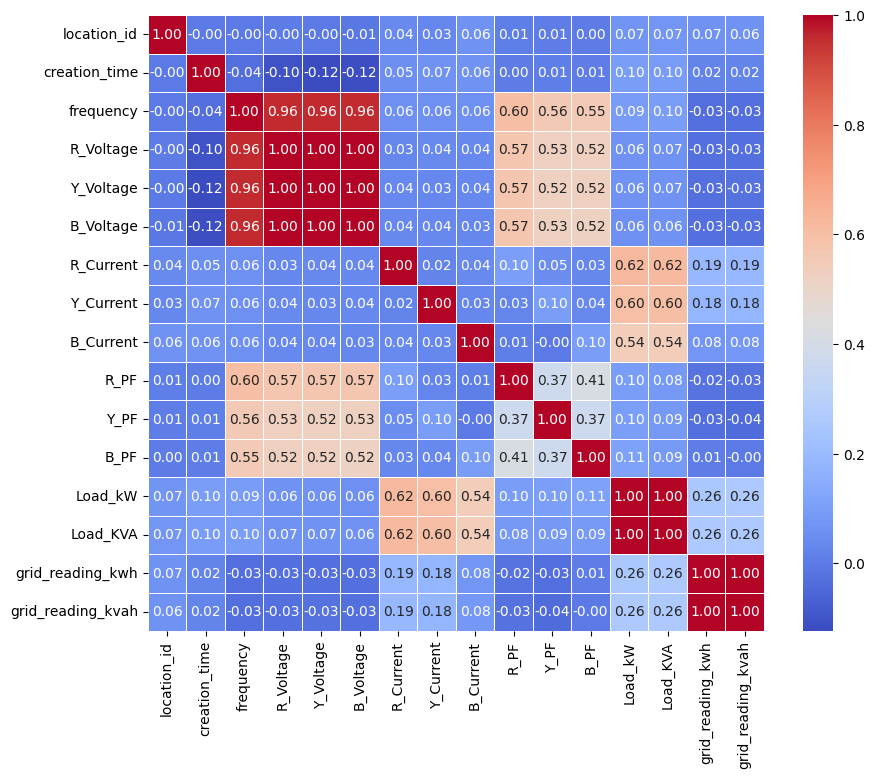

In [11]:
correlation_matrix = data.iloc[:,:-1].corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
# Show the plot
plt.show()

In [ ]:
import requests
from datetime import datetime
def getweatherdata(location_id):
    try:
        lst = [

               ]

        pipeline = [
            {"$match": {'type': 'AC', 'admin_status': {"$in": ['N', 'S', 'U']},
                        'site_id': {"$in": lst}}},
            {"$group": {
                "_id": "$site_id",
                "latitude": {"$min": "$latitude"},
                "longitude": {"$min": "$longitude"},
                "sensors": {
                    "$addToSet": {"id": "$id", "name": "$name", "latitude": "$latitude", "longitude": "$longitude"}}
            }}
        ]

        # Execute the pipeline and retrieve the result
        result = list(collection_name7.aggregate(pipeline))
        print(result)

        # Construct data to be inserted into MongoDB
        bulk_insert_data = []

        # Iterate over each site
        for site_data in result:
            url = f"https://archive-api.open-meteo.com/v1/archive?latitude={site_data['latitude']}&longitude={site_data['longitude']}&start_date=2024-08-02&end_date=2024-07-15&hourly=temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m"
            print(url)
            response = requests.get(url)
            response.raise_for_status()
            weather_data = response.json()

            # Process weather data if available
            if "hourly" in weather_data:
                for i in range(len(weather_data['hourly']['time'])):
                    hour_data = {
                        "_id": f"{site_data['_id']}_{weather_data['hourly']['time'][i]}",  # MongoDB's unique identifier
                        "site_id": site_data["_id"],
                        "time": weather_data['hourly']['time'][i],
                        "temperature_2m": weather_data['hourly'].get('temperature_2m', [])[i],
                        "relative_humidity_2m": weather_data['hourly'].get('relative_humidity_2m', [])[i],
                        "apparent_temperature": weather_data['hourly'].get('apparent_temperature', [])[i],
                        "precipitation": weather_data['hourly'].get('precipitation', [])[i],
                        "wind_speed_10m": weather_data['hourly'].get('wind_speed_10m', [])[i],
                        "wind_speed_100m": weather_data['hourly'].get('wind_speed_100m', [])[i],
                        "creation_time_iso": datetime.utcfromtimestamp(
                            datetime.strptime(weather_data['hourly']['time'][i],
                                              '%Y-%m-%dT%H:%M').timestamp()).isoformat()
                    }

                    bulk_insert_data.append(hour_data)

                    # print(bulk_insert_data)

        # Insert the data into MongoDB in bulk
        if bulk_insert_data:
            # collection_name8.insert_many(bulk_insert_data)
            return {"message": "Weather data fetched and stored successfully"}
        else:
            return {"message": "No weather data available for the specified sites"}

    except Exception as e:
        return {"error": str(e)}

In [4]:
data.loc[:,'consumption_level'] = 0
data

C:\Users\HARSH\AppData\Local\Temp\ipykernel_15036\3508769353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'consumption_level'] = 0


,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason,consumption_level
0,100000020805,2024-07-01 00:00:00,50.00,243.10,246.20,240.90,0.00,0.00,0.26,1.00,1.00,1.00,0.07,0.07,7548.00,7822.00,No Consumption,0
1,100000031104,2024-07-01 00:00:00,50.00,243.80,247.00,241.50,0.26,1.61,0.70,1.00,0.99,0.73,0.64,0.69,9233.00,9766.00,No Consumption,0
2,100000040406,2024-07-01 00:00:00,50.00,243.00,247.10,242.50,0.22,0.00,1.44,1.00,1.00,1.00,0.45,0.45,8309.00,8777.00,Success,0
3,100000040701,2024-07-01 00:00:03,50.00,243.10,246.90,242.10,3.69,3.30,0.63,0.97,0.99,0.80,1.80,1.86,22971.00,23774.00,No Consumption,0
4,100000020806,2024-07-01 00:00:03,50.00,243.00,246.70,240.80,0.00,6.65,0.00,1.00,1.00,1.00,1.64,1.64,4288.00,4666.00,No Consumption,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957099,100000020006,2024-07-31 23:59:53,50.00,248.40,250.80,249.10,0.00,0.00,0.58,1.00,1.00,0.97,0.14,0.15,2665.00,2961.00,No Consumption,0
1957100,100000030505,2024-07-31 23:59:53,50.00,249.50,250.20,249.00,0.20,0.08,6.39,0.98,1.00,0.99,1.66,1.68,13373.00,13697.00,No Consumption,0
1957101,100000041205,2024-07-31 23:59:55,50.00,248.30,251.50,247.80,0.00,0.29,2.08,1.00,0.67,0.93,0.52,0.58,24176.00,25079.00,No Consumption,0
1957102,100000030506,2024-07-31 23:59:56,50.00,249.80,249.80,249.50,0.89,2.26,0.00,0.99,0.96,1.00,0.99,1.01,7094.00,7841.00,No Consumption,0


In [5]:
data_length = len(data)
no_of_feeders = data['location_id'].nunique()
threshold = (data_length/no_of_feeders)/20
print(data_length,no_of_feeders,threshold)


1957104 340 287.8094117647059


In [6]:
data.iloc[:, 2:14].describe()

,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA
count,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00,1957104.00
mean,49.37,241.80,243.54,241.82,0.91,0.89,0.81,0.92,0.91,0.91,0.62,0.65
std,5.64,28.42,28.66,28.46,1.79,1.76,1.56,0.17,0.18,0.18,0.74,0.75
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,0.00,0.00
25%,50.00,239.20,240.70,238.90,0.03,0.04,0.05,0.94,0.92,0.92,0.14,0.17
50%,50.00,244.60,246.70,244.90,0.33,0.32,0.33,0.99,0.99,0.99,0.32,0.36
75%,50.00,250.60,252.20,250.70,0.76,0.75,0.72,1.00,1.00,1.00,0.82,0.86
max,51.00,268.60,268.40,265.10,25.16,24.46,27.03,1.00,1.00,1.00,13.61,14.39


In [21]:
df1 = data.copy()
i=0
for id , dt1 in df1[df1['Load_kW']>3].groupby('location_id'):
    if len(dt1)>threshold:
        data.loc[data['location_id']==id,'consumption_level']=1
        i+=1
        # print(f"{id},{len(dt1)}")
    if len(dt1)>(threshold*2):
        data.loc[data['location_id']==id,'consumption_level']=2
        # print(f"{id},{len(dt1)}")
print(i)
        # data[data['location_id']==id]['Load_kW'].plot()
        # plt.title((id))
        # plt.show()

24


In [22]:
data[data['consumption_level']==1]['location_id'].nunique()

14

In [25]:
df3 = data[data['consumption_level']==0]#['location_id'].nunique()
# df3.describe()[:,3:]
df3.iloc[:, 2:14].describe()
# df3

,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA
count,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00,1822909.00
mean,49.37,241.81,243.54,241.82,0.81,0.80,0.77,0.92,0.91,0.91,0.56,0.59
std,5.62,28.38,28.61,28.41,1.57,1.58,1.48,0.17,0.18,0.18,0.66,0.66
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,0.00,0.00
25%,50.00,239.20,240.70,238.90,0.03,0.03,0.05,0.94,0.93,0.92,0.13,0.16
50%,50.00,244.60,246.70,244.90,0.31,0.30,0.32,0.99,0.99,0.99,0.30,0.33
75%,50.00,250.60,252.20,250.70,0.71,0.71,0.69,1.00,1.00,1.00,0.73,0.77
max,51.00,268.60,268.40,265.10,25.16,19.28,22.56,1.00,1.00,1.00,6.09,6.87


In [34]:
df3[df3['Load_kW']>5]#['location_id'].unique()

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason,consumption_level
59554,100000010106,2024-07-01 22:07:02,50.20,233.70,238.20,234.10,14.76,0.04,7.62,0.99,1.00,0.99,5.27,5.31,9567.00,10203.00,No Consumption,0
60500,100000010705,2024-07-01 22:27:29,50.20,233.50,237.70,235.80,11.89,0.28,9.41,0.99,0.82,0.99,5.05,5.08,20180.00,21353.00,Success,0
362308,100000010903,2024-07-06 15:44:27,50.00,245.30,251.10,247.90,18.59,0.74,0.91,1.00,0.99,1.00,5.09,5.14,15498.00,16351.00,No Consumption,0
633173,100000010106,2024-07-10 21:51:58,50.00,242.90,246.40,244.20,13.51,6.11,4.25,0.97,0.34,0.99,6.08,6.17,9728.00,10378.00,No Consumption,0
673219,100000011202,2024-07-11 12:55:47,50.00,229.50,232.90,230.70,25.16,0.27,0.54,0.92,0.93,0.95,6.09,6.09,11965.00,12419.00,Success,0
673991,100000010402,2024-07-11 13:12:39,50.00,234.50,237.60,234.90,8.55,12.11,0.57,0.99,0.99,1.00,5.06,5.08,17008.00,17771.00,Success,0
740789,100000010701,2024-07-12 13:54:39,50.00,236.60,239.60,236.80,0.67,11.11,0.30,0.93,0.99,0.91,5.59,5.64,4910.00,5070.00,No Consumption,0
1014383,100000010106,2024-07-16 20:55:28,50.00,238.30,240.30,239.40,14.68,0.13,7.97,0.98,0.90,1.00,5.45,5.49,9829.00,10486.00,Success,0
1014804,100000010106,2024-07-16 21:05:05,50.00,238.50,241.20,239.30,14.64,0.92,7.71,0.98,0.84,0.99,5.52,5.60,9830.00,10487.00,Success,0
1015233,100000010106,2024-07-16 21:14:46,50.00,239.10,241.10,239.10,7.43,0.86,7.64,0.98,0.76,0.99,5.42,5.53,9831.00,10488.00,Success,0


In [35]:
df3[df3['Load_kW']>4].groupby('location_id').count().reset_index()[['location_id',"frequency"]].head(60)#['Load_kW'].plot()

,location_id,frequency
0,100000010002,9
1,100000010104,20
2,100000010105,1
3,100000010106,49
4,100000010201,3
5,100000010203,1
6,100000010205,3
7,100000010305,10
8,100000010306,1
9,100000010401,7


In [37]:
df3[df3['Load_kW']>4].groupby('location_id').count().reset_index()[['location_id',"frequency"]].iloc[59:].head(60)#['Load_kW'].plot()

,location_id,frequency
59,100000030202,1
60,100000030204,11
61,100000030205,34
62,100000030206,4
63,100000030303,2
64,100000030304,2
65,100000030306,5
66,100000030406,4
67,100000030502,2
68,100000030503,32


In [11]:
meter_consumption = df.groupby('location_id')['Load_kW'].sum().reset_index()
meter_consumption

,location_id,Load_kW
0,100000010001,282.57
1,100000010002,3903.88
2,100000010003,2359.03
3,100000010004,52.83
4,100000010101,5263.19
...,...,...
335,100000041404,3166.71
336,100000050306,4017.64
337,100000190001,12780.06
338,100000190011,1389.25


In [12]:
meter_consumption.describe()

,location_id,Load_kW
count,340.00,340.00
mean,100000027532.66,3559.69
std,18734.60,2174.31
min,100000010001.00,0.00
25%,100000020177.25,2194.07
50%,100000030103.00,3240.32
75%,100000031805.25,4733.27
max,100000190016.00,13836.05


In [ ]:
100000030501,100000030504,100000030701,100000190001,100000011203

In [67]:
data[data['location_id']==100000190011].describe()

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah
count,4429.00,4429,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00,4429.00
mean,100000190011.00,2024-07-16 12:23:44.022352640,49.40,241.20,244.11,242.12,0.00,1.51,0.00,0.99,0.71,0.99,0.31,0.37,17428.39,17575.09
min,100000190011.00,2024-07-01 00:02:51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.79,0.00,0.00,0.00,17318.00,17445.00
25%,100000190011.00,2024-07-08 17:41:32,50.00,238.20,241.20,239.50,0.00,0.67,0.00,1.00,0.58,1.00,0.10,0.16,17369.00,17506.00
50%,100000190011.00,2024-07-16 12:56:13,50.00,243.90,247.00,244.90,0.00,0.70,0.00,1.00,0.61,1.00,0.10,0.18,17424.00,17571.00
75%,100000190011.00,2024-07-24 06:28:44,50.00,250.10,252.80,250.80,0.00,1.43,0.00,1.00,0.92,1.00,0.31,0.34,17484.00,17641.00
max,100000190011.00,2024-07-31 23:50:51,50.30,262.50,264.60,262.20,0.00,13.35,0.00,1.00,1.00,1.00,2.98,3.01,17551.00,17716.00
std,0.00,NaN,5.44,27.82,28.06,27.80,0.00,1.83,0.00,0.11,0.19,0.11,0.45,0.44,67.99,79.01


In [53]:
data[data['location_id']==100000011203]

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
346,100000011203,2024-07-01 00:07:22,50.00,244.10,247.80,243.70,4.81,0.05,0.20,1.00,1.00,0.65,1.21,1.24,24233.00,24520.00,No Consumption
779,100000011203,2024-07-01 00:16:47,50.00,244.50,248.40,243.80,3.55,0.06,0.20,0.99,1.00,0.66,0.89,0.92,24233.00,24520.00,No Consumption
1222,100000011203,2024-07-01 00:26:07,50.00,244.70,248.50,245.10,2.75,0.07,0.18,0.99,1.00,0.70,0.70,0.73,24234.00,24520.00,Success
1667,100000011203,2024-07-01 00:35:42,50.00,244.80,248.70,246.40,2.74,0.07,0.18,0.98,1.00,0.70,0.70,0.72,24234.00,24520.00,No Consumption
2123,100000011203,2024-07-01 00:45:19,50.00,244.80,248.70,246.40,2.74,0.07,0.18,0.98,1.00,0.70,0.70,0.72,24234.00,24520.00,No Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955201,100000011203,2024-07-31 23:17:15,50.00,248.70,252.70,250.20,14.44,0.00,0.23,0.99,1.00,0.49,3.59,3.65,25325.00,25625.00,No Consumption
1955628,100000011203,2024-07-31 23:27:14,50.00,248.40,252.80,250.10,14.42,0.00,0.21,0.99,1.00,0.45,3.57,3.63,25326.00,25625.00,Success
1956057,100000011203,2024-07-31 23:36:38,50.00,248.40,251.90,249.50,14.40,0.00,0.21,0.99,1.00,0.43,3.58,3.63,25327.00,25626.00,Success
1956475,100000011203,2024-07-31 23:45:59,50.00,248.40,251.90,249.50,14.40,0.00,0.21,0.99,1.00,0.43,3.58,3.63,25327.00,25626.00,No Consumption


In [19]:
df = data.copy()
# Define thresholds for consumption categories
low_threshold = 1  # Example threshold for low consumption (adjust as necessary)
high_threshold = 5  # Example threshold for high consumption (adjust as necessary)
# Create a new column 'consumption_category' based on Load_kW
df['consumption_category'] = pd.cut(df['Load_kW'], 
                                    bins=[-float('inf'), low_threshold, high_threshold, float('inf')], 
                                    labels=['low', 'medium', 'high'])

# Now you can filter the data for different consumption categories
low_consumption_df = df[df['consumption_category'] == 'low']
medium_consumption_df = df[df['consumption_category'] == 'medium']
high_consumption_df = df[df['consumption_category'] == 'high']

# Print to check the distribution
print(f"Low Consumption Meters: {len(low_consumption_df)}")
print(f"Medium Consumption Meters: {len(medium_consumption_df)}")
print(f"High Consumption Meters: {len(high_consumption_df)}")


Low Consumption Meters: 1540672
Medium Consumption Meters: 401012
High Consumption Meters: 279


In [24]:
# Load your dataset
df = data.copy()
# Group the data by location_id and sum the total Load_kW for each meter
meter_consumption = df.groupby('location_id')['Load_kW'].sum().reset_index()

# Define thresholds for consumption categories
low_threshold = meter_consumption['Load_kW'].quantile(0.33)  # Lower 33% for low consumption
high_threshold = meter_consumption['Load_kW'].quantile(0.66) # Upper 33% for high consumption

# Categorize meters based on their total Load_kW
meter_consumption['consumption_category'] = pd.cut(meter_consumption['Load_kW'], 
                                                   bins=[-float('inf'), low_threshold, high_threshold, float('inf')], 
                                                   labels=['low', 'medium', 'high'])

# Filter out meters based on their consumption category
low_consumption_meters = meter_consumption[meter_consumption['consumption_category'] == 'low']['location_id']
medium_consumption_meters = meter_consumption[meter_consumption['consumption_category'] == 'medium']['location_id']
high_consumption_meters = meter_consumption[meter_consumption['consumption_category'] == 'high']['location_id']

# Now you can use these meter IDs to filter the original data
low_consumption_df = df[df['location_id'].isin(low_consumption_meters)]
medium_consumption_df = df[df['location_id'].isin(medium_consumption_meters)]
high_consumption_df = df[df['location_id'].isin(high_consumption_meters)]

# Print to check the distribution
print(f"Low Consumption Meters: {len(low_consumption_meters)}")
print(f"Medium Consumption Meters: {len(medium_consumption_meters)}")
print(f"High Consumption Meters: {len(high_consumption_meters)}")


Low Consumption Meters: 111
Medium Consumption Meters: 111
High Consumption Meters: 114


In [28]:
low_consumption_df['Load_kW'].max()

4.97

<Axes: >

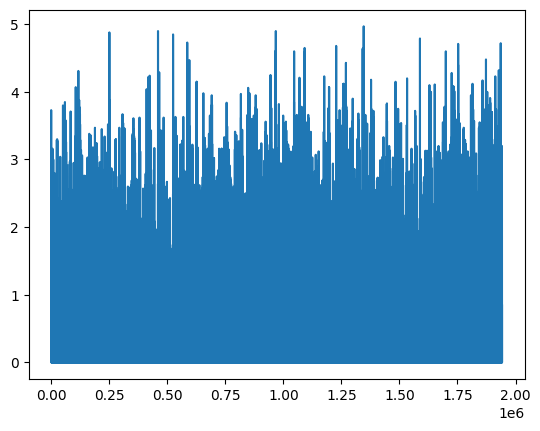

In [30]:
low_consumption_df['Load_kW'].plot()

6.08


<Axes: >

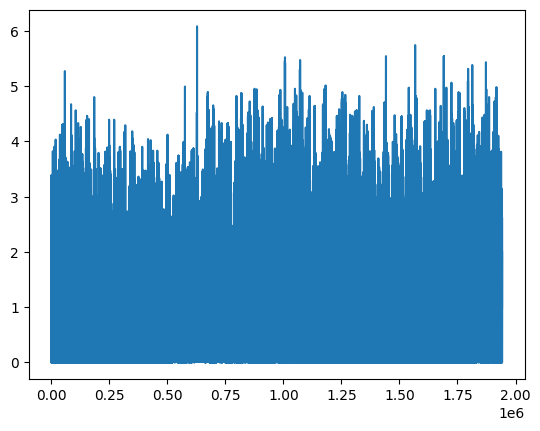

In [31]:
print(medium_consumption_df['Load_kW'].max())
medium_consumption_df['Load_kW'].plot()

8.02


<Axes: >

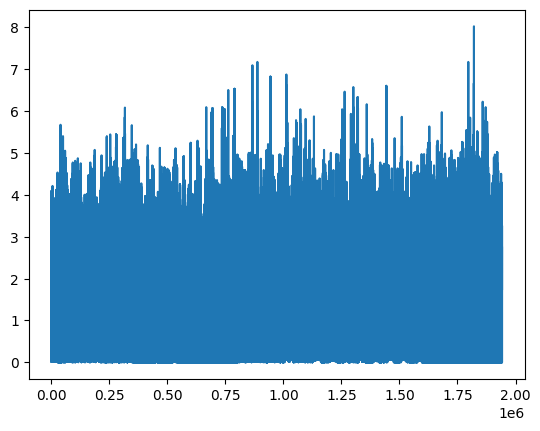

In [32]:
print(high_consumption_df['Load_kW'].max())
high_consumption_df['Load_kW'].plot()

In [23]:
low_consumption_df['location_id'].nunique()

336

In [22]:
medium_consumption_df['location_id'].nunique()

319

In [21]:
high_consumption_df['location_id'].nunique()

25

In [18]:
data.loc[data['Load_kW']<4]

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
0,100000020805,2024-07-01 00:00:00,50.00,243.10,246.20,240.90,0.00,0.00,0.26,1.00,1.00,1.00,0.07,0.07,7548.00,7822.00,No Consumption
1,100000031104,2024-07-01 00:00:00,50.00,243.80,247.00,241.50,0.26,1.61,0.70,1.00,0.99,0.73,0.64,0.69,9233.00,9766.00,No Consumption
2,100000040406,2024-07-01 00:00:00,50.00,243.00,247.10,242.50,0.22,0.00,1.44,1.00,1.00,1.00,0.45,0.45,8309.00,8777.00,Success
3,100000040701,2024-07-01 00:00:03,50.00,243.10,246.90,242.10,3.69,3.30,0.63,0.97,0.99,0.80,1.80,1.86,22971.00,23774.00,No Consumption
4,100000020806,2024-07-01 00:00:03,50.00,243.00,246.70,240.80,0.00,6.65,0.00,1.00,1.00,1.00,1.64,1.64,4288.00,4666.00,No Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941958,100000020006,2024-07-31 23:59:53,50.00,248.40,250.80,249.10,0.00,0.00,0.58,1.00,1.00,0.97,0.14,0.15,2665.00,2961.00,No Consumption
1941959,100000030505,2024-07-31 23:59:53,50.00,249.50,250.20,249.00,0.20,0.08,6.39,0.98,1.00,0.99,1.66,1.68,13373.00,13697.00,No Consumption
1941960,100000041205,2024-07-31 23:59:55,50.00,248.30,251.50,247.80,0.00,0.29,2.08,1.00,0.67,0.93,0.52,0.58,24176.00,25079.00,No Consumption
1941961,100000030506,2024-07-31 23:59:56,50.00,249.80,249.80,249.50,0.89,2.26,0.00,0.99,0.96,1.00,0.99,1.01,7094.00,7841.00,No Consumption


In [8]:
dff = data.copy()
lst = []
max_value = dff['Load_kW'].max()
for i in range(int(max_value) + 1):
    df1 = dff[(dff['Load_kW']>i)& (dff['Load_kW']<=i+1)]
    print(f"{i}-{i+1} {str(len(df1)).ljust(7)} {df1['location_id'].nunique()}")
    if i==5:
        lst.extend(list(df1['location_id'].unique()))
    # print(i)



0-1 1385889 329
1-2 278970  319
2-3 97662   305
3-4 20738   240
4-5 3642    151
5-6 236     24
6-7 38      8
7-8 4       2
8-9 1       1


In [10]:
dff = data[data['location_id'].isin([
    100000031103, 100000030701, 100000040206, 100000010106, 100000010705, 100000031005, 100000040502, 100000031506, 100000010903, 100000030501, 100000031701,100000010402, 100000030302, 100000010701, 100000010801, 100000031105, 100000040504, 100000040701, 100000031601, 100000010101, 100000011004, 100000030503, 100000040103, 100000010502
    ])]
dff

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
3,100000040701,2024-07-01 00:00:03,50.00,243.10,246.90,242.10,3.69,3.30,0.63,0.97,0.99,0.80,1.80,1.86,22971.00,23774.00,No Consumption
5,100000031105,2024-07-01 00:00:03,50.00,243.60,246.70,242.00,0.10,0.26,2.19,0.80,0.67,1.00,0.64,0.67,18473.00,19748.00,No Consumption
22,100000031506,2024-07-01 00:00:25,50.00,243.70,246.60,240.50,0.00,0.85,0.34,1.00,0.99,0.98,0.31,0.31,24140.00,25452.00,No Consumption
38,100000031701,2024-07-01 00:00:46,50.00,243.30,247.00,242.50,0.22,4.08,0.38,0.98,1.00,0.98,1.21,1.21,15329.00,15888.00,No Consumption
53,100000031601,2024-07-01 00:01:04,50.00,243.70,246.60,241.20,0.04,0.31,0.07,1.00,0.98,1.00,0.09,0.10,11896.00,12294.00,No Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941827,100000040206,2024-07-31 23:57:05,50.00,248.70,252.20,248.20,5.80,2.74,0.67,0.96,1.00,1.00,2.32,2.37,21108.00,22708.00,No Consumption
1941836,100000040504,2024-07-31 23:57:18,50.00,248.40,251.80,247.80,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,22235.00,22688.00,No Consumption
1941927,100000030302,2024-07-31 23:59:11,50.00,249.20,249.70,247.80,4.67,0.74,0.57,0.99,0.84,0.99,1.58,1.61,20847.00,21265.00,No Consumption
1941947,100000030501,2024-07-31 23:59:41,50.20,250.30,250.10,248.10,1.21,1.91,5.31,1.00,0.99,0.95,2.07,2.13,13484.00,13776.00,No Consumption


In [14]:
for id in dff['location_id'].unique():  
    print(id)


100000040701
100000031105
100000031506
100000031701
100000031601
100000030302
100000010101
100000030501
100000010106
100000030701
100000010502
100000031005
100000010402
100000010701
100000010705
100000031103
100000010903
100000010801
100000011004
100000040103
100000040206
100000040502
100000040504
100000030503


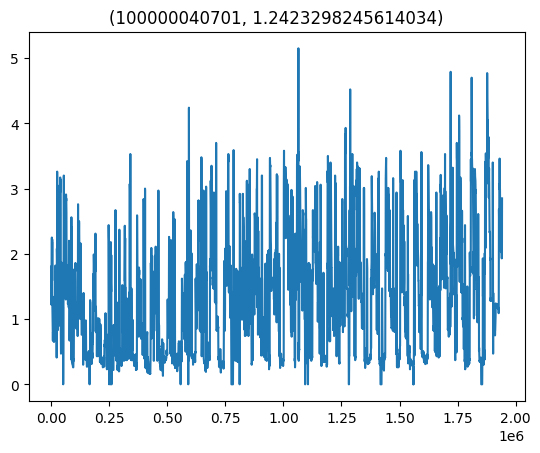

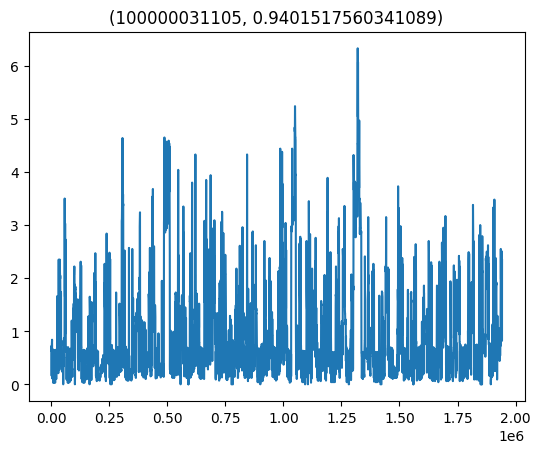

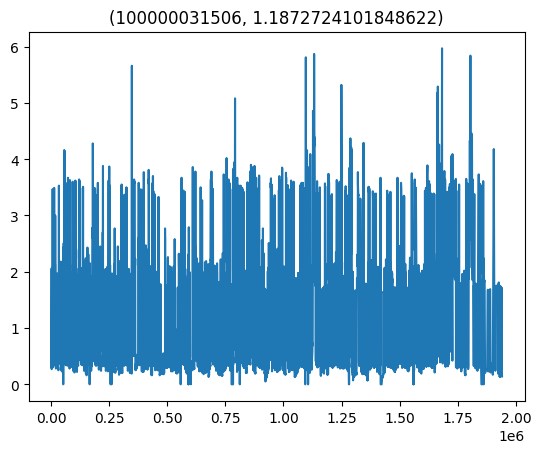

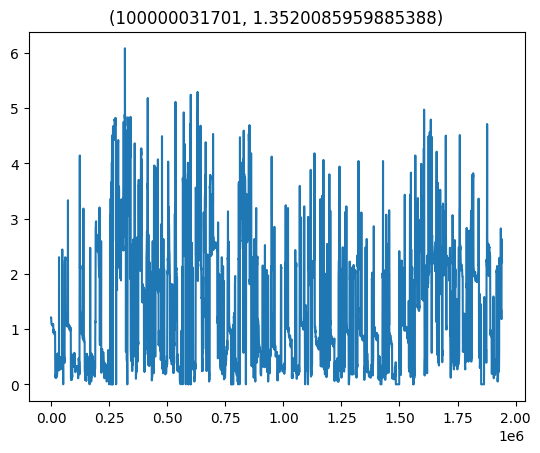

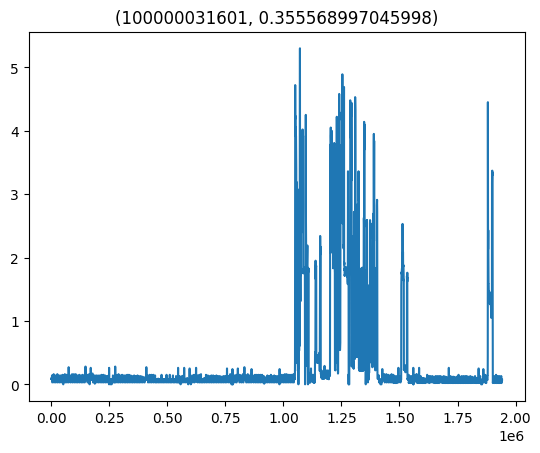

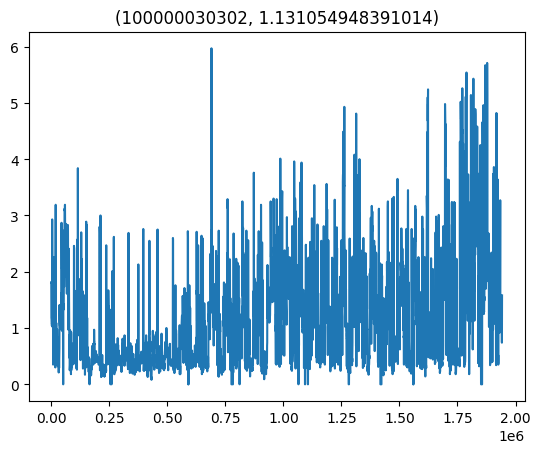

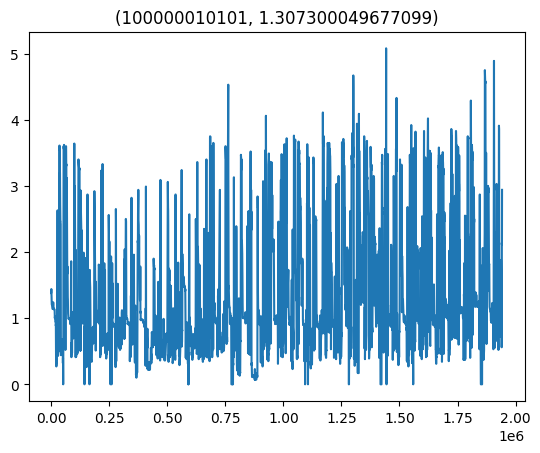

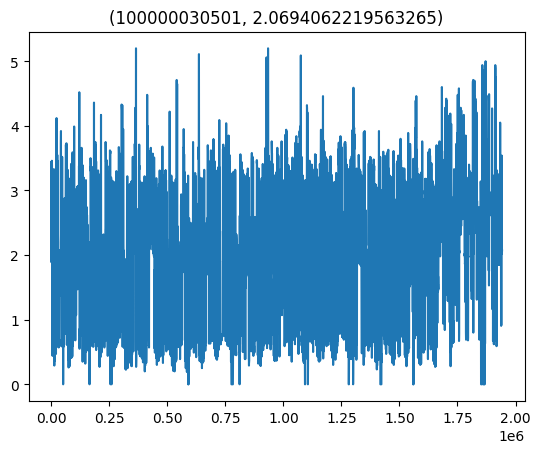

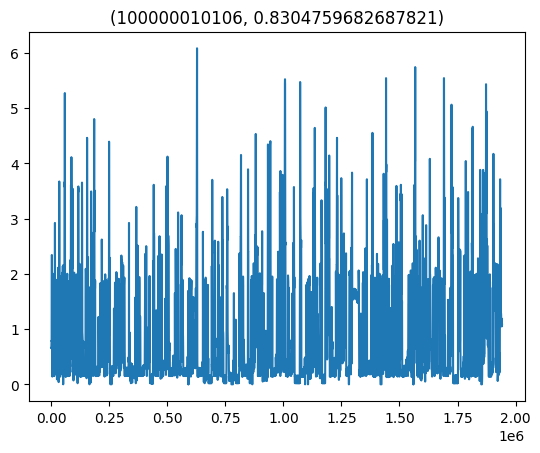

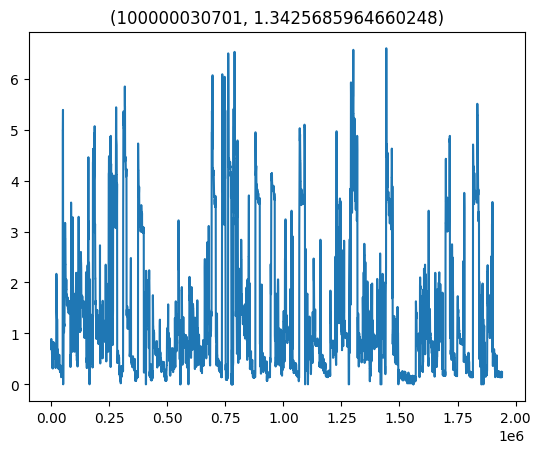

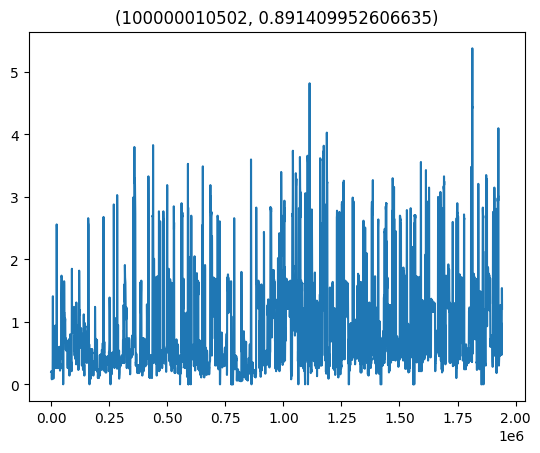

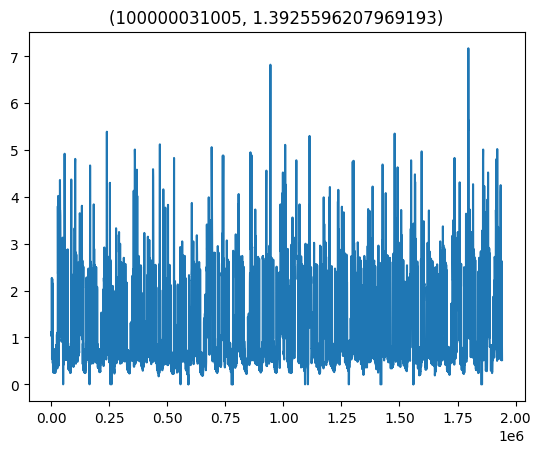

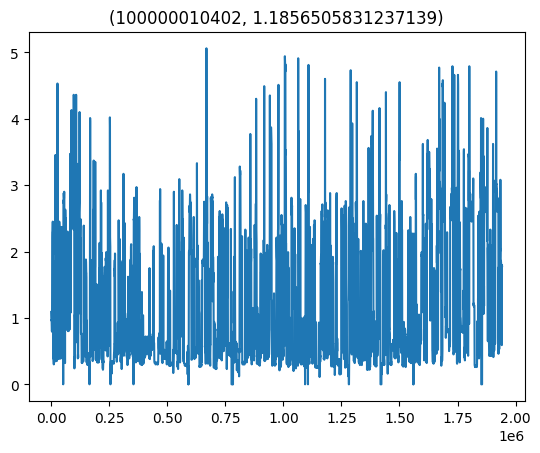

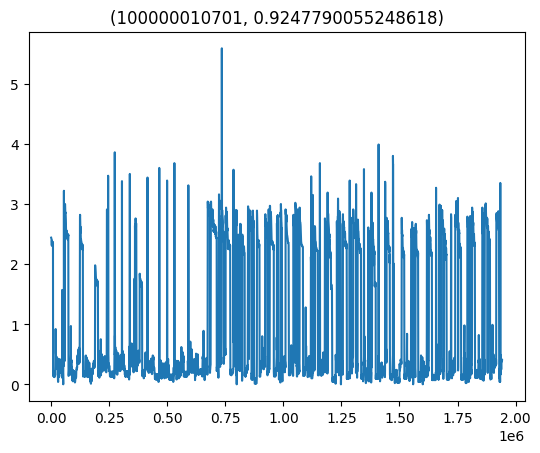

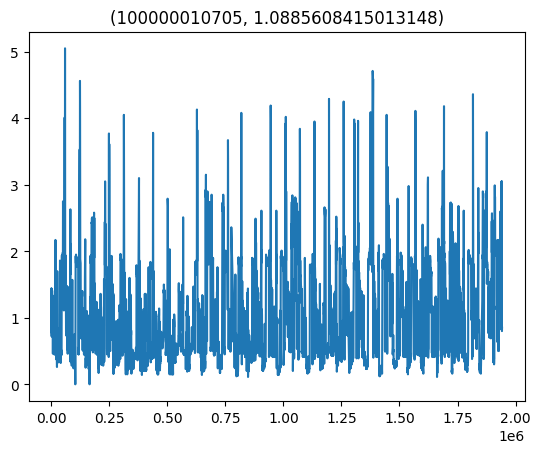

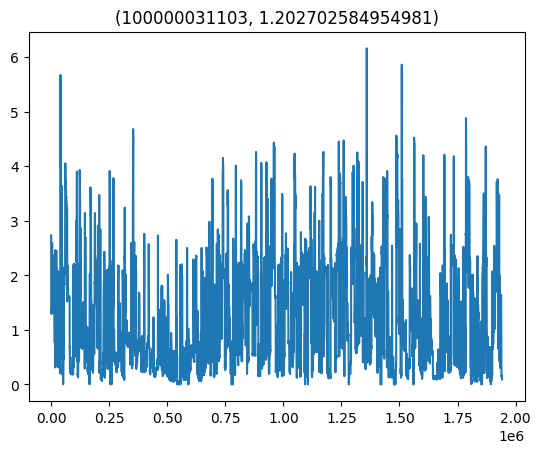

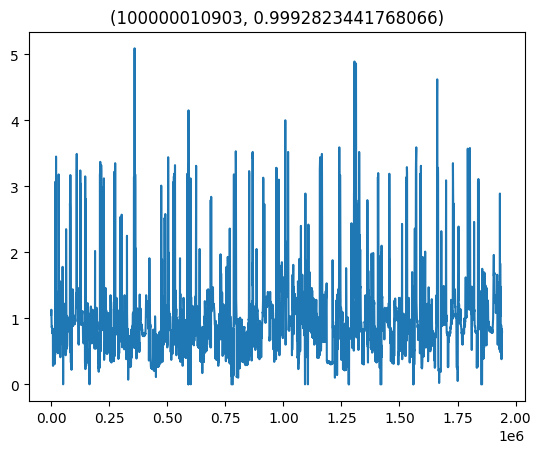

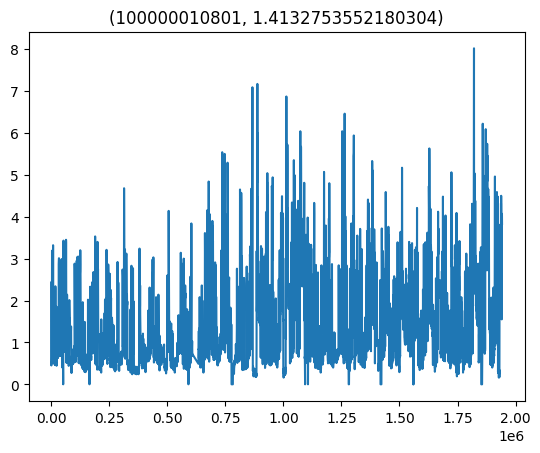

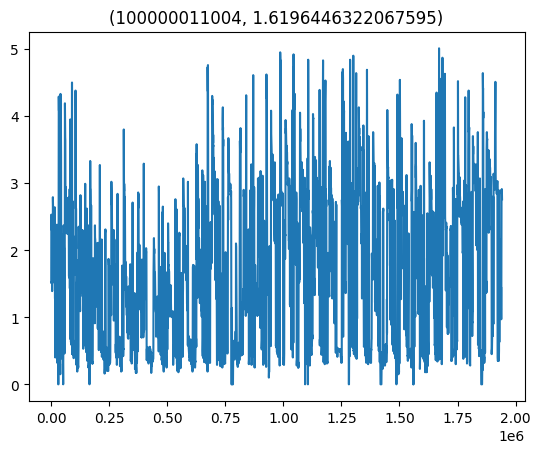

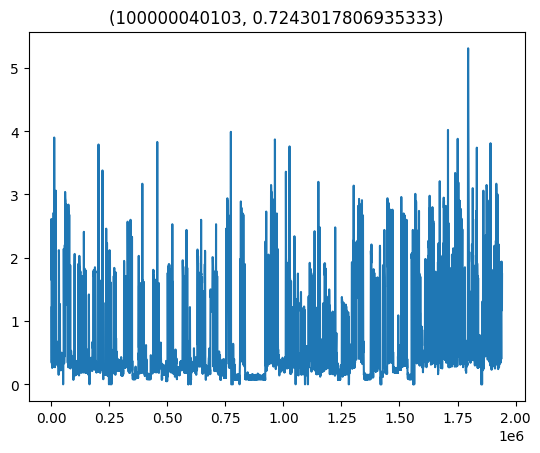

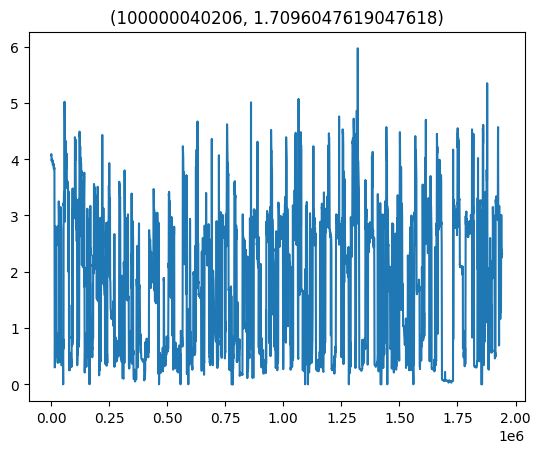

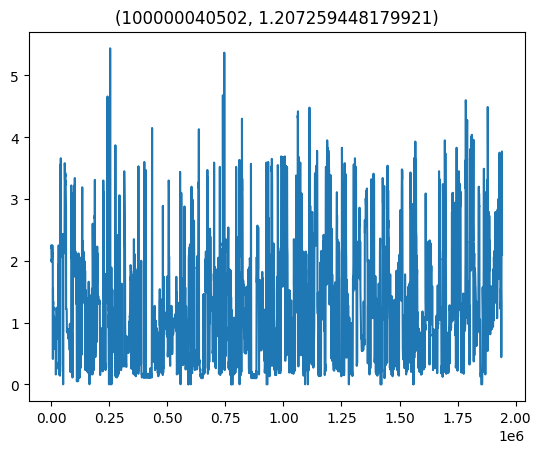

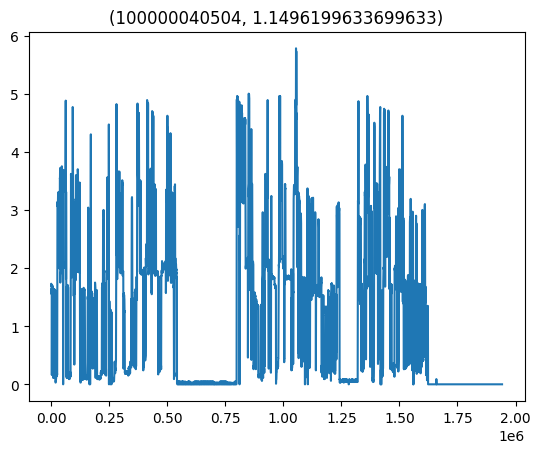

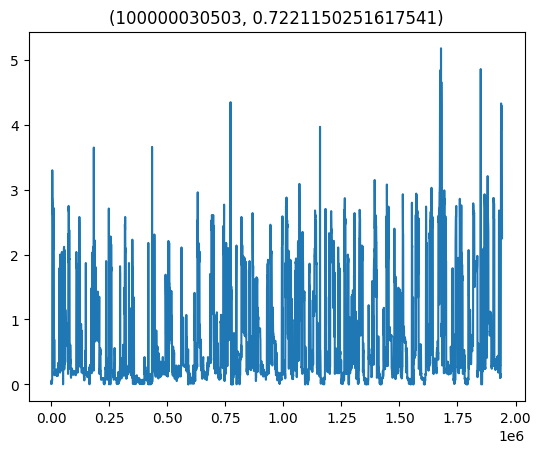

In [17]:
for id in dff['location_id'].unique():
    dff[dff['location_id']==id]['Load_kW'].plot()
    plt.title((id,dff[dff['location_id']==id]['Load_kW'].mean()))
    plt.show()

In [9]:
lst

[100000031103,
 100000030701,
 100000040206,
 100000010106,
 100000010705,
 100000031005,
 100000040502,
 100000031506,
 100000010903,
 100000030501,
 100000031701,
 100000010402,
 100000030302,
 100000010701,
 100000010801,
 100000031105,
 100000040504,
 100000040701,
 100000031601,
 100000010101,
 100000011004,
 100000030503,
 100000040103,
 100000010502]

In [76]:
data

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
0,100000020805,2024-07-01 00:00:00,50.00,243.10,246.20,240.90,0.00,0.00,0.26,1.00,1.00,1.00,0.07,0.07,7548.00,7822.00,No Consumption
1,100000031104,2024-07-01 00:00:00,50.00,243.80,247.00,241.50,0.26,1.61,0.70,1.00,0.99,0.73,0.64,0.69,9233.00,9766.00,No Consumption
2,100000040406,2024-07-01 00:00:00,50.00,243.00,247.10,242.50,0.22,0.00,1.44,1.00,1.00,1.00,0.45,0.45,8309.00,8777.00,Success
3,100000040701,2024-07-01 00:00:03,50.00,243.10,246.90,242.10,3.69,3.30,0.63,0.97,0.99,0.80,1.80,1.86,22971.00,23774.00,No Consumption
4,100000020806,2024-07-01 00:00:03,50.00,243.00,246.70,240.80,0.00,6.65,0.00,1.00,1.00,1.00,1.64,1.64,4288.00,4666.00,No Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941958,100000020006,2024-07-31 23:59:53,50.00,248.40,250.80,249.10,0.00,0.00,0.58,1.00,1.00,0.97,0.14,0.15,2665.00,2961.00,No Consumption
1941959,100000030505,2024-07-31 23:59:53,50.00,249.50,250.20,249.00,0.20,0.08,6.39,0.98,1.00,0.99,1.66,1.68,13373.00,13697.00,No Consumption
1941960,100000041205,2024-07-31 23:59:55,50.00,248.30,251.50,247.80,0.00,0.29,2.08,1.00,0.67,0.93,0.52,0.58,24176.00,25079.00,No Consumption
1941961,100000030506,2024-07-31 23:59:56,50.00,249.80,249.80,249.50,0.89,2.26,0.00,0.99,0.96,1.00,0.99,1.01,7094.00,7841.00,No Consumption


In [78]:
data['Load_kW'].max()

8.02

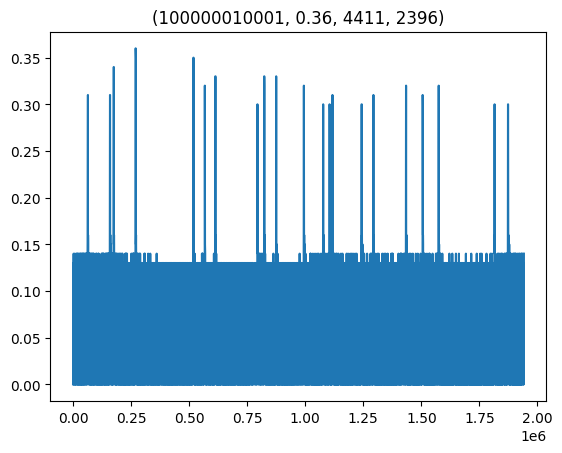

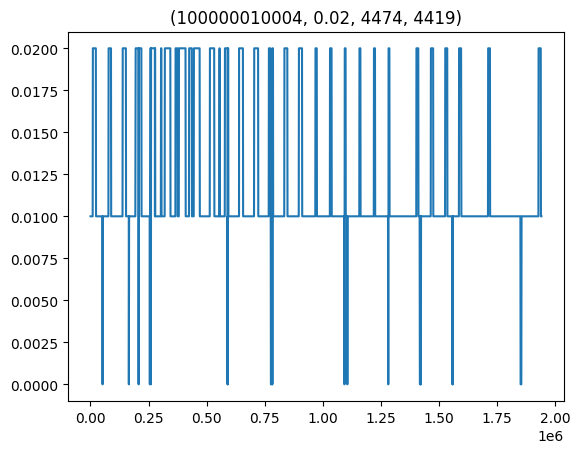

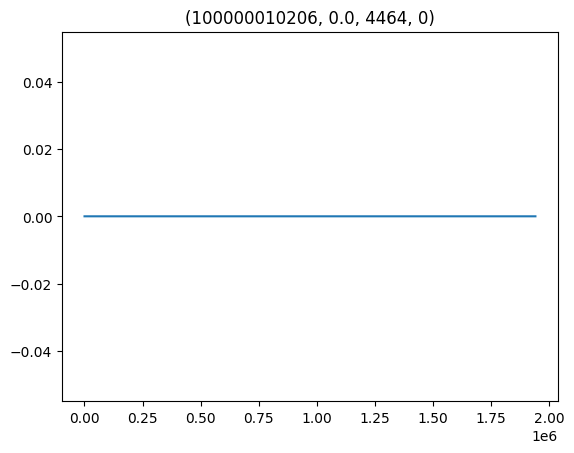

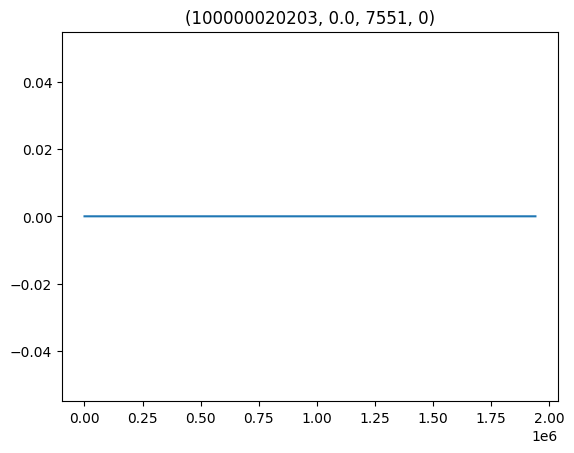

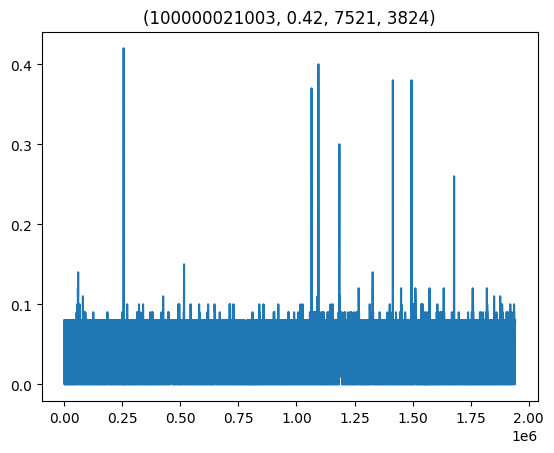

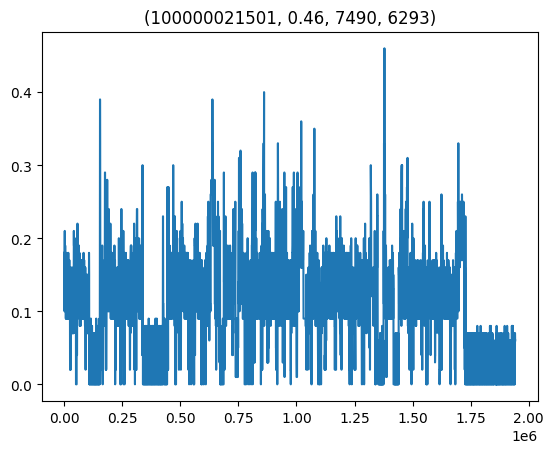

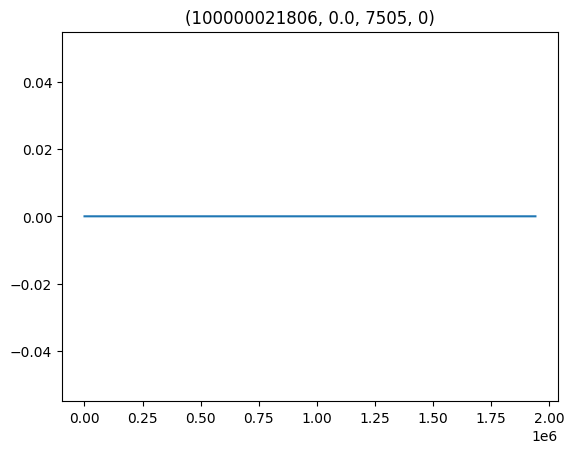

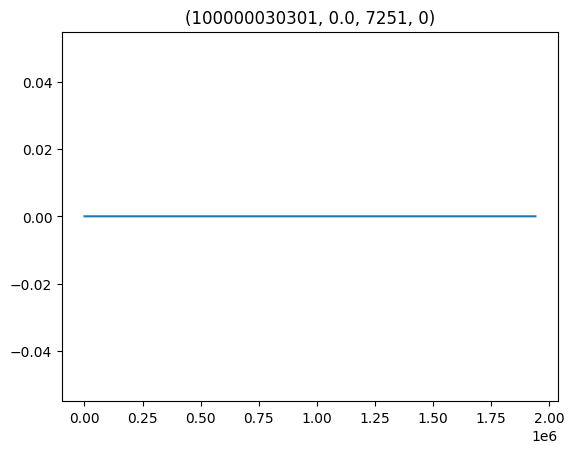

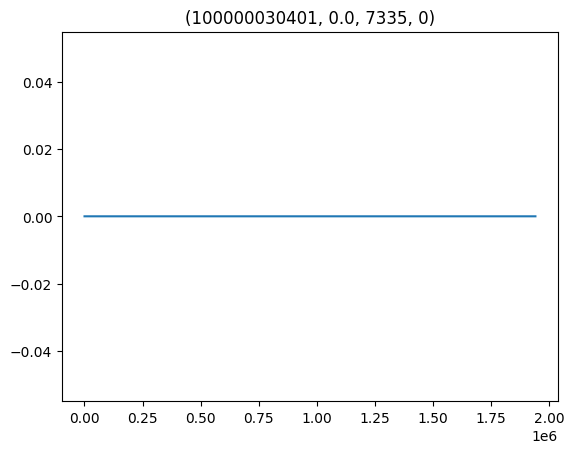

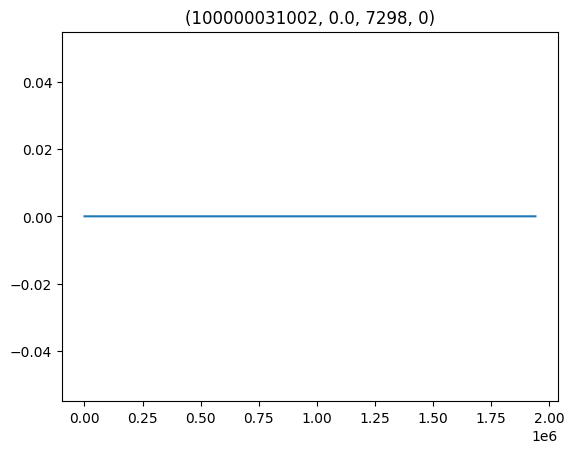

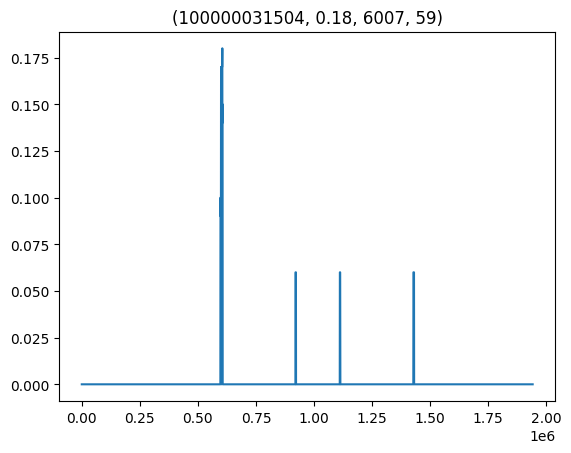

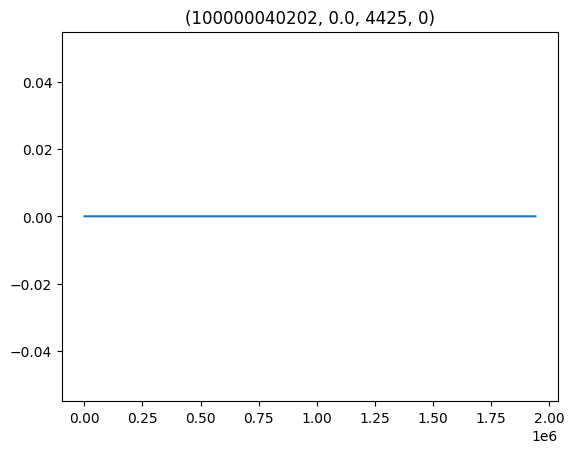

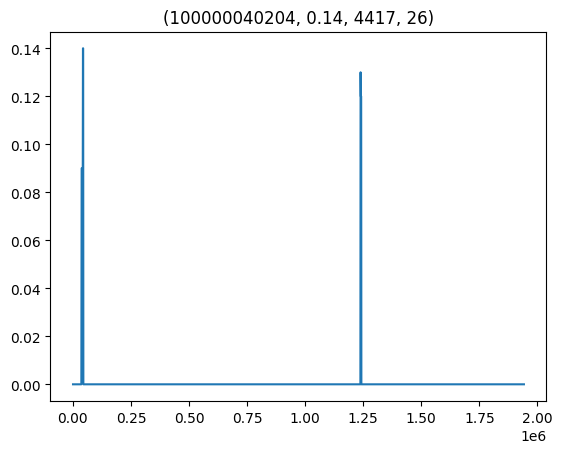

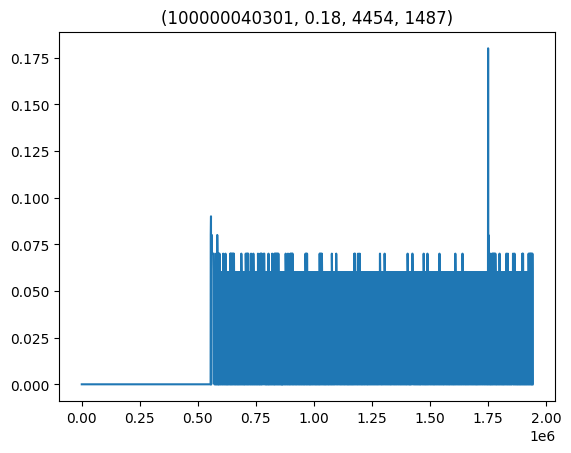

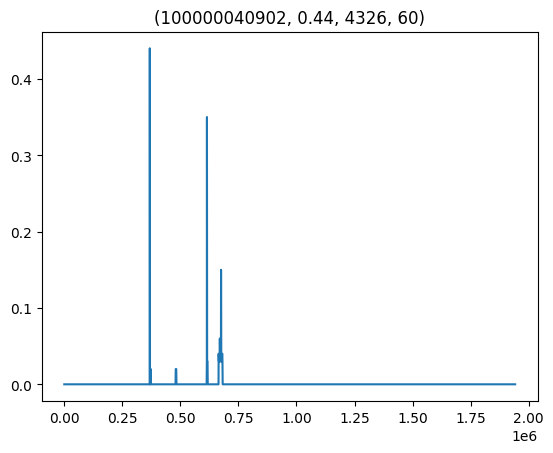

In [85]:
# df2 = data.groupby('loaction_id')
for id ,data1 in data.groupby('location_id'):
    max_load_value = data1['Load_kW'].max()
    if max_load_value <0.5:
        data1['Load_kW'].plot()
        plt.title((id,max_load_value,len(data1),len(data1[(data1['Load_kW']>0)& (data1['Load_kW']<1)])))
        plt.show()
        # print(id,max_load_value)


In [59]:
l1 = df1['location_id'].unique()
l2 = data['location_id'].unique()

In [63]:
difference = set(l2) - set(l1)

print(difference)

{100000030401, 100000040202, 100000020203, 100000021806, 100000031002, 100000030301, 100000010206}


In [65]:
data[data['location_id']==100000030401].describe()

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah
count,7335.00,7335,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00,7335.00
mean,100000030401.00,2024-07-16 09:59:17.272528896,49.15,240.59,242.41,240.74,0.00,0.00,0.00,0.98,0.98,0.98,0.00,0.00,233.00,274.00
min,100000030401.00,2024-07-01 00:02:56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,233.00,274.00
25%,100000030401.00,2024-07-08 15:32:04,50.00,238.90,240.60,238.90,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,233.00,274.00
50%,100000030401.00,2024-07-16 07:54:38,50.00,244.40,246.60,244.90,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,233.00,274.00
75%,100000030401.00,2024-07-24 04:21:50,50.00,250.50,252.00,250.50,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,233.00,274.00
max,100000030401.00,2024-07-31 23:58:50,50.30,262.00,264.30,263.00,0.06,0.07,0.04,1.00,1.00,1.00,0.00,0.00,233.00,274.00
std,0.00,NaN,6.47,32.51,32.74,32.53,0.01,0.01,0.00,0.13,0.13,0.13,0.00,0.00,0.00,0.00


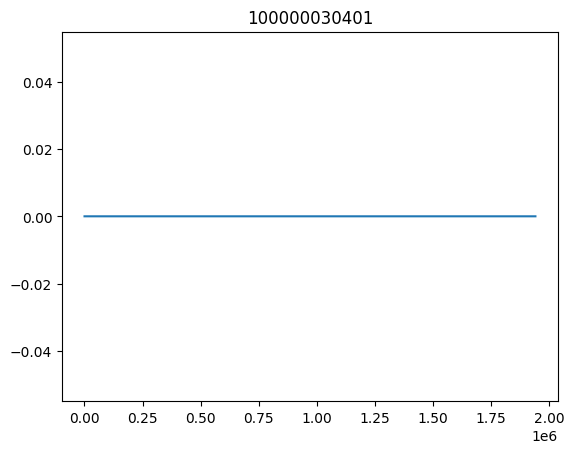

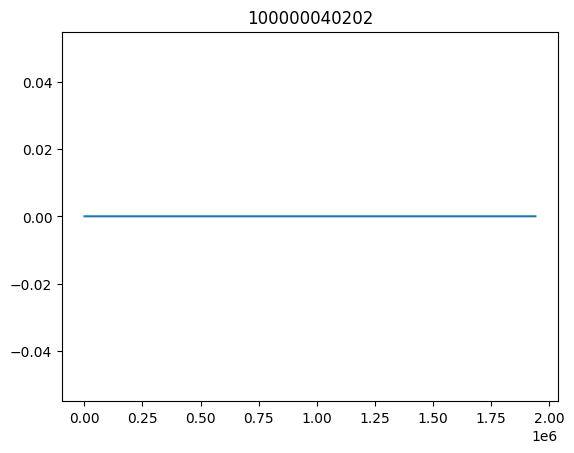

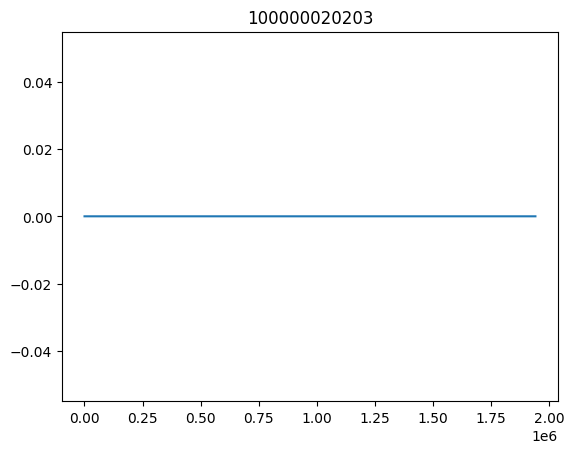

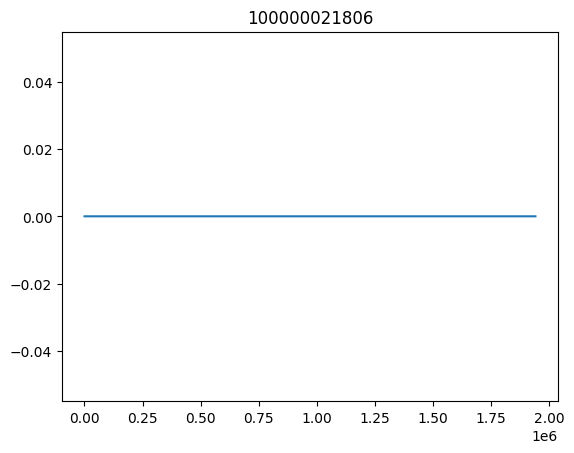

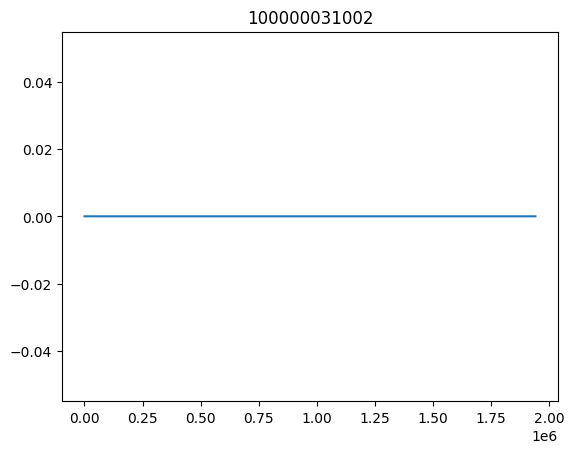

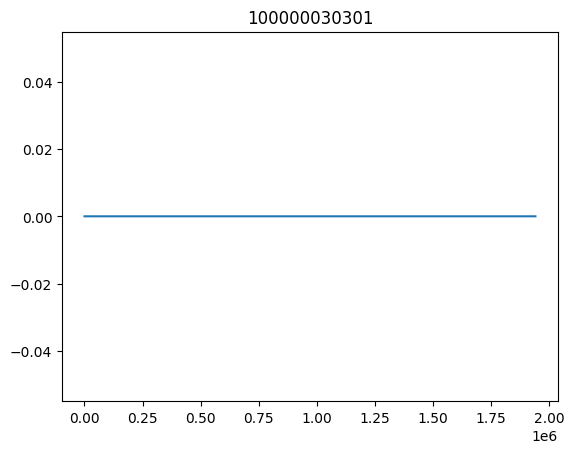

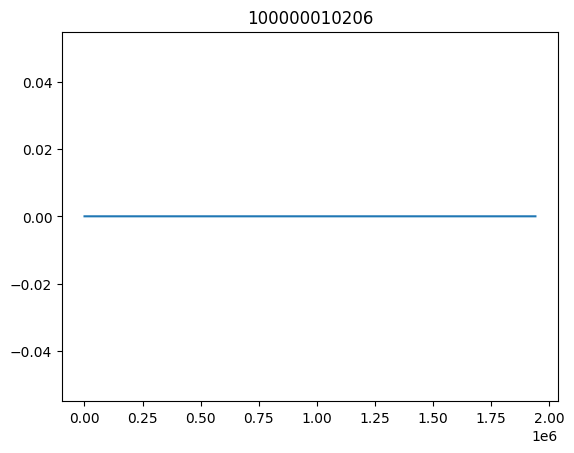

In [67]:
for id in difference:
    data[data['location_id']==id]['Load_kW'].plot()
    plt.title(id)
    plt.show()

In [55]:
data[data['location_id']==100000010801].describe()

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah
count,4082.00,4082,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00,4082.00
mean,100000010801.00,2024-07-16 12:08:35.308672512,49.38,241.61,244.30,242.39,2.08,1.95,1.69,0.97,0.89,0.91,1.41,1.45,20256.03,21015.37
min,100000010801.00,2024-07-01 00:06:19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.97,-0.90,0.00,0.00,19781.00,20529.00
25%,100000010801.00,2024-07-08 14:05:52.500000,50.00,239.10,241.40,239.30,1.25,0.16,0.67,0.98,0.87,0.92,0.57,0.61,19962.25,20717.25
50%,100000010801.00,2024-07-16 15:36:41,50.00,244.40,247.40,245.40,1.61,0.32,0.87,0.99,0.99,0.99,0.97,1.01,20221.00,20981.50
75%,100000010801.00,2024-07-24 05:11:51.500000,50.00,250.30,253.10,251.30,2.33,2.86,1.56,0.99,1.00,0.99,2.03,2.06,20528.00,21292.00
max,100000010801.00,2024-07-31 23:54:22,50.30,261.60,265.70,263.30,13.37,18.28,16.50,1.00,1.00,1.00,8.02,8.06,20851.00,21620.00
std,0.00,NaN,5.55,28.08,28.45,28.25,1.74,3.08,1.96,0.11,0.22,0.18,1.14,1.13,313.33,319.03


In [ ]:
100000010801,100000031005
[100000031701, 100000010106, 100000011202, 100000030701,100000010801, 100000031005, 100000031105, 100000031103]

In [53]:
data[data['Load_kW']>6]['location_id'].unique()

array([100000031701, 100000010106, 100000011202, 100000030701,
       100000010801, 100000031005, 100000031105, 100000031103],
      dtype=int64)

## voltage

In [37]:
data = df.copy()

In [38]:
voltage = 265
print("location_id: ",data.loc[(data['R_Voltage'] > voltage) | (data['Y_Voltage'] > voltage) | (data['B_Voltage'] > voltage)]['location_id'].nunique())
print("data counts: ",len(data.loc[(data['R_Voltage'] > voltage) | (data['Y_Voltage'] > voltage) | (data['B_Voltage'] > voltage)]))
data.loc[(data['R_Voltage'] > voltage) | (data['Y_Voltage'] > voltage) | (data['B_Voltage'] > voltage)].head(5)

# data.loc[data['B_Voltage']>voltage]

location_id:  145
data counts:  2217


,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
211699,100000040105,2024-07-04 04:05:16,50.00,260.10,265.10,256.80,0.60,0.00,1.59,0.66,1.00,0.93,0.48,0.56,8348.00,9061.00,No Consumption
211722,100000040303,2024-07-04 04:05:40,50.00,260.00,265.10,257.80,0.67,0.26,0.82,0.96,1.00,-0.40,0.46,0.47,6456.00,6536.00,No Consumption
211727,100000040305,2024-07-04 04:05:46,50.00,260.20,265.10,256.90,1.33,0.03,0.66,0.46,1.00,0.92,0.32,0.52,8207.00,9551.00,No Consumption
211729,100000050306,2024-07-04 04:05:49,50.00,260.20,265.10,257.10,0.26,0.27,1.94,0.78,0.55,0.99,0.63,0.68,12501.00,13672.00,No Consumption
211759,100000040505,2024-07-04 04:06:23,50.00,259.90,265.20,257.40,0.09,0.30,0.05,1.00,1.00,0.73,0.11,0.12,5524.00,5814.00,No Consumption


In [39]:
no_voltage_df = data[(data['R_Voltage'] == 0) | (data['Y_Voltage'] == 0) | (data['B_Voltage'] == 0)]
a = no_voltage_df[no_voltage_df['Load_kW']!=0]
a[a['error_reason']=="Success"]
# a['error_reason'].unique()

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
40561,100000011203,2024-07-01 14:30:45,50.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.01,1.01,1.03,24246.00,24532.00,Success
301923,100000021204,2024-07-05 13:19:35,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,Success
531997,100000030406,2024-07-09 00:02:46,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,1.00,2.09,2.16,14526.00,15175.00,Success
756062,100000010101,2024-07-12 09:59:14,50.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,1.00,1.03,1.03,12403.00,12589.00,Success
867725,100000030605,2024-07-14 03:26:03,50.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.01,2.03,2.08,8571.00,8884.00,Success
896364,100000031803,2024-07-14 13:30:55,50.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.01,1.41,1.47,24321.00,26319.00,Success


In [41]:
b = data.loc[data['location_id']==100000021204]
# b.loc[b['Date_Time']=="2024-07-05"]
# b[b['Date_Time'].dt.date == pd.to_datetime("2024-07-05 13").date()]
b[(b['creation_time'].dt.date == pd.to_datetime("2024-07-05").date()) &(b['creation_time'].dt.hour == 13)]

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
301112,100000021204,2024-07-05 13:01:57,50.00,245.70,247.70,246.10,0.69,1.19,0.24,1.00,1.00,0.18,0.50,0.53,8150.00,8504.00,No Consumption
301376,100000021204,2024-07-05 13:07:42,50.20,250.30,251.80,250.10,1.07,1.58,0.25,0.99,0.73,0.17,0.55,0.57,8150.00,8504.00,No Consumption
301665,100000021204,2024-07-05 13:13:37,50.20,250.30,251.80,250.10,1.07,1.58,0.25,0.99,0.73,0.17,0.55,0.57,8150.00,8504.00,No Consumption
301923,100000021204,2024-07-05 13:19:35,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,Success
302208,100000021204,2024-07-05 13:25:36,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,No Consumption
302469,100000021204,2024-07-05 13:31:15,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,No Consumption
302733,100000021204,2024-07-05 13:36:49,50.00,247.60,250.70,248.40,1.37,0.05,0.24,0.99,1.00,0.18,0.36,0.41,8151.00,8504.00,No Consumption
303015,100000021204,2024-07-05 13:42:50,50.00,247.60,250.70,248.40,1.37,0.05,0.24,0.99,1.00,0.18,0.36,0.41,8151.00,8504.00,No Consumption
303286,100000021204,2024-07-05 13:48:42,50.00,244.60,248.10,246.60,1.37,0.46,0.24,0.99,0.83,0.18,0.44,0.51,8151.00,8504.00,No Consumption
303560,100000021204,2024-07-05 13:54:46,50.00,244.60,248.10,246.60,1.37,0.46,0.24,0.99,0.83,0.18,0.44,0.51,8151.00,8504.00,No Consumption


In [43]:
b = data.loc[data['location_id']==100000021204]
# b.loc[b['Date_Time']=="2024-07-05"]
# b[b['Date_Time'].dt.date == pd.to_datetime("2024-07-05 13").date()]
b[(b['creation_time'].dt.date == pd.to_datetime("2024-07-05").date()) &(b['creation_time'].dt.hour >= 13)].sort_values("creation_time").head(25)

,location_id,creation_time,frequency,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW,Load_KVA,grid_reading_kwh,grid_reading_kvah,error_reason
301112,100000021204,2024-07-05 13:01:57,50.00,245.70,247.70,246.10,0.69,1.19,0.24,1.00,1.00,0.18,0.50,0.53,8150.00,8504.00,No Consumption
301376,100000021204,2024-07-05 13:07:42,50.20,250.30,251.80,250.10,1.07,1.58,0.25,0.99,0.73,0.17,0.55,0.57,8150.00,8504.00,No Consumption
301665,100000021204,2024-07-05 13:13:37,50.20,250.30,251.80,250.10,1.07,1.58,0.25,0.99,0.73,0.17,0.55,0.57,8150.00,8504.00,No Consumption
301923,100000021204,2024-07-05 13:19:35,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,Success
302208,100000021204,2024-07-05 13:25:36,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,No Consumption
302469,100000021204,2024-07-05 13:31:15,50.20,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,1.00,1.00,0.21,0.28,8151.00,8504.00,No Consumption
302733,100000021204,2024-07-05 13:36:49,50.00,247.60,250.70,248.40,1.37,0.05,0.24,0.99,1.00,0.18,0.36,0.41,8151.00,8504.00,No Consumption
303015,100000021204,2024-07-05 13:42:50,50.00,247.60,250.70,248.40,1.37,0.05,0.24,0.99,1.00,0.18,0.36,0.41,8151.00,8504.00,No Consumption
303286,100000021204,2024-07-05 13:48:42,50.00,244.60,248.10,246.60,1.37,0.46,0.24,0.99,0.83,0.18,0.44,0.51,8151.00,8504.00,No Consumption
303560,100000021204,2024-07-05 13:54:46,50.00,244.60,248.10,246.60,1.37,0.46,0.24,0.99,0.83,0.18,0.44,0.51,8151.00,8504.00,No Consumption


## load

In [ ]:
load_value = 5
print("no of meters: ",data.loc[data['Load_kW']>load_value]['location_id'].nunique())
print("no of data points: ",len(data.loc[data['Load_kW']>load_value]))
data.loc[data['Load_kW']>load_value]


In [ ]:
c = data[data['location_id']==100000040206]
c[c['Load_kW']>4]

## current


In [ ]:
current_value = 10
# data = data.loc[~((data['R-Current']>current_value)|(data['Y-Current']>current_value)|(data['B-Current']>current_value))]#['location_id'].unique()
for id, data2 in data.loc[((data['R_Current']>current_value)|(data['Y_Current']>current_value)|(data['B_Current']>current_value))].groupby('location_id'):#['location_id'].unique()
    print(id,len(data2))

data cleaning checks

In [ ]:
load_condition= (
    data['Load kW']>data['Load KVA']
)
data.loc[load_condition]
# data = data.loc[~load_condition]

In [74]:
frequency_PF_condition = (
    (data['frequency'] !=0) & ((data['frequency'] > 51) | (data['frequency'] < 49))  |
    (data['R-PF'] > 1) | (data['Y-PF'] > 1) | (data['B-PF'] > 1) |  # Check if any PF is greater than 1
    (data['R-PF'] < -1) | (data['Y-PF'] < -1) | (data['B-PF'] < -1)    # Check if any PF is less than 0
)  
data = data.loc[~frequency_PF_condition]

voltage_condition = (((data['R-Voltage'] == 0) & (data['Y-Voltage'] == 0) & (data['B-Voltage'] == 0)) &
    ((data['Load kW']!=0 )|
    ((data['R-Current'] != 0) & (data['B-Current'] != 0) & (data['Y-Current'] != 0)))
)
data = data.loc[~voltage_condition]

current_condition = (
    ((data['R-Current'] == 0) & (data['Y-Current'] == 0) & (data['B-Current'] == 0)) &
    ((data['Load kW']>0.03) | (data['Load KVA']>0.03))
                     )
data = data.loc[~current_condition]

load_condition= (
    data['Load kW']>data['Load KVA']
)
data = data.loc[~load_condition]
# voltage = 260
# max_voltage_condition = (
#     ((data['R-Voltage']>voltage)|(data['Y-Voltage']>voltage)|(data['B-Voltage']>voltage))
# )
# data.loc[max_voltage_condition]
# data.loc[max_voltage_condition]['location_id'].nunique()

In [75]:
# voltage = 261
# max_voltage_condition = (
#     ((data['R-Voltage']>voltage)|(data['Y-Voltage']>voltage)|(data['B-Voltage']>voltage))
# )
# data.loc[max_voltage_condition]['location_id'].nunique()

In [ ]:
data.iloc[:, 2:14].describe()

In [ ]:
current_value = 10
# data = data.loc[~((data['R-Current']>current_value)|(data['Y-Current']>current_value)|(data['B-Current']>current_value))]#['location_id'].unique()
for id, data2 in data.loc[((data['R_Current']>current_value)|(data['Y_Current']>current_value)|(data['B_Current']>current_value))].groupby('location_id'):#['location_id'].unique()
    print(id,len(data2))

In [ ]:
data[['Date-Time','location_id']].duplicated()

In [ ]:
data.loc[data[['Date-Time','location_id']].duplicated()][data.loc[data[['Date-Time','location_id']].duplicated()]['location_id']==100000021003].sort_values("Date-Time").head(60)

In [ ]:
data.columns

In [ ]:
dff = data[['R-Voltage', 'Y-Voltage','B-Voltage', 'R-Current', 'Y-Current', 'B-Current', 'R-PF', 'Y-PF','B-PF', 'Load kW', 'Load KVA']].copy()
dff

In [ ]:
dff_norm = (dff - dff.min()) / (dff.max() - dff.min())
dff_norm


In [ ]:
dff.describe()

In [ ]:
plt.scatter(data.index,data['Load kW'])

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['Load kW']].pivot_table(index=data.index, values='Load kW', aggfunc='mean').T, cmap='coolwarm', cbar=True)


In [ ]:
value_counts = data['Load kW'].value_counts().sort_index()

# Convert to a DataFrame and transpose for heatmap plotting
value_counts_df = pd.DataFrame(value_counts)

# Create the heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(value_counts_df, annot=True, cmap='Blues', cbar=False, fmt='d')


In [ ]:
# 100000190001 ,100000030201 ,100000011203 

In [ ]:
data.iloc[:, 2:14].describe()

In [ ]:
correlation_matrix = data.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
# Show the plot
plt.show()

In [ ]:
# box plot
columns_to_plot = ['R-Current', 'Y-Current', 'B-Current']
data.boxplot(column=columns_to_plot)
plt.title('Box Plot for Calculated R, Y, B ')
plt.show()

In [ ]:
# 5. Date-Time processing
# converting each into an into an individual objects

data['Date-Time'] = pd.to_datetime(data['Date-Time'])
data['Day'] = data['Date-Time'].dt.day
data['Month'] = data['Date-Time'].dt.month
data['Minute'] = data['Date-Time'].dt.minute
data['Hour'] = data['Date-Time'].dt.hour
data['day_of_week'] = data['Date-Time'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

# to be removed
#data['month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
#data['day_sin'] = np.sin(2 * np.pi * data['Day'] / 31)
#data['hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)

#
data['power_R'] = data['R-Current'] * data['R-Voltage'] * data['R-PF']
data['power_Y'] = data['Y-Current'] * data['Y-Voltage'] * data['Y-PF']
data['power_B'] = data['B-Current'] * data['B-Voltage'] * data['B-PF']
data['total_power'] = (data['power_R'] + data['power_Y'] + data['power_B']) / 1000
data['power_loss'] = (data['total_power'] - data['Load kW'])
# data['Load kW'] = (data['total_power']-data['power_loss'])
data

In [ ]:
# box plot
columns_to_plot = ['power_R', 'power_Y', 'power_B']
data.boxplot(column=columns_to_plot)
plt.title('Box Plot for Calculated power R, Y, B ')
plt.show()

In [ ]:
# box plot
columns_to_plot = ['total_power']
data.boxplot(column=columns_to_plot)
plt.title('Box Plot for Total Power')
plt.show()

In [ ]:
# box plot
columns_to_plot = ['power_loss']
data.boxplot(column=columns_to_plot)
plt.title('Box Plot for Power Loss')
plt.show()

In [ ]:
data.set_index('Date-Time', inplace=True)
hourly_avg = data.resample('h').mean()
hourly_avg = hourly_avg.reset_index()

for column in ['R-Voltage', 'Y-Voltage', 'B-Voltage']:
    hourly_avg = hourly_avg[np.abs(hourly_avg[column] - hourly_avg[column].mean()) <= (3*hourly_avg[column].std())]

for column in ['R-Voltage', 'Y-Voltage', 'B-Voltage']:
    data = data[np.abs(data[column] - data[column].mean()) <= (3*data[column].std())]
hourly_avg

In [ ]:
# plot distribution
data['power_B'].plot(kind='kde')

In [ ]:
#'power_R', 'power_Y', 'power_B'
data['power_R'].plot(kind='hist', edgecolor='black')

In [ ]:
# Scatter plot with day against tip
plt.plot(data['power_R'])
plt.plot(data['power_Y'])
plt.plot(data['power_B'])
 
# Adding Title to the Plot
plt.title("Scatter Plot")
 
# Setting the X and Y labels
plt.xlabel('Reading NO')
plt.ylabel('Power')
 
plt.show()

In [ ]:
plt.plot(data['total_power'])
 
# Adding Title to the Plot
plt.title("Scatter Plot")
 
# Setting the X and Y labels
plt.xlabel('Reading Numbers')
plt.ylabel('Total Power')

 
plt.show()

In [ ]:
correlation_matrix = data.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
# Show the plot
plt.show()